In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from RobotSim373 import *

Version:  0.0.31


In [3]:
def build(robot):
    box1=Box(robot,3,9.5,name='right')  # location given, width=height=1.0 default
    box2=Box(robot,3,11.5,name='left')
    
    connect(box1,box2,'weld')

    disk1=Disk(robot,2,10.5,name='center')  # radius = 0.5 default
    
    connect(disk1,box1,'distance')
    connect(disk1,box2,'distance')
    
    

In [4]:
def forward(t,robot):
    robot['left'].F=10
    robot['right'].F=10
    return True

def backward(t,robot):
    robot['left'].F=-10
    robot['right'].F=-10
    return True

def until_close(t,robot):
    distance=robot['center'].read_distance()
    if distance<10:
        return True
    
def until_far(t,robot):
    distance=robot['center'].read_distance()
    if distance>10:
        return True    

In [5]:
from collections import OrderedDict

class StateMachine(object):

    def __init__(self,*args,name=None):
        self.__name__=name
        
        self.functions={}
        self.states=OrderedDict()
        
        for i,arg in enumerate(args):
            if isinstance(arg[0],tuple) or isinstance(arg[0],list):
                key=arg[0][0].__name__
                self.states[key]={'actions':arg[0],"next":arg[1]}
                for func in arg[0]:
                    self.functions[func.__name__]=func
            else:
                func=arg[0]
                key=arg[0].__name__
                self.states[key]={'actions':[arg[0]],"next":arg[1]}
                self.functions[func.__name__]=func
        
        self.states["_end_simulation"]={'actions':None,"next":None}
        
        self.first_state=list(self.states.keys())[0]    

        for key in self.states:
            if key=="_end_simulation":
                continue
            next_state=self.states[key]['next']
            if next_state not in self.states:
                raise ValueError(f"Key '{next_state}' not found in {self.states.keys()}")
        
        

In [7]:
state_machine=StateMachine(
    (forward,'until_close'),
    (until_close,'backward'),
    (backward,'until_far'),
    (until_far,'forward'),
)

In [8]:
state_machine.states

OrderedDict([('forward',
              {'actions': [<function __main__.forward(t, robot)>],
               'next': 'until_close'}),
             ('until_close',
              {'actions': [<function __main__.until_close(t, robot)>],
               'next': 'backward'}),
             ('backward',
              {'actions': [<function __main__.backward(t, robot)>],
               'next': 'until_far'}),
             ('until_far',
              {'actions': [<function __main__.until_far(t, robot)>],
               'next': 'forward'}),
             ('_end_simulation', {'actions': None, 'next': None})])

In [9]:
def monitor(t,robot):
    robot.message=robot.controller.current_state,robot['left'].read_distance(),robot['right'].read_distance(),robot['center'].angle


In [13]:
   

class Controller(object):
    """
        forward_stop=StateMachine(
            (forward,'until_close'),
            ( (until_close,stop),'_end_simulation'),
            name='forward_stop'
        )

        state_machine=StateMachine(
            (forward,'until_close'),
            ( (until_close,stop),'look_left'),
            ( (look_left,save_distance_left,wait(2)),'look_right'),
            ( (look_right,save_distance_right,wait(2)),'look_straight'),
            (look_straight,'choose_right_or_left'),
            (choose_right_or_left,'_end_simulation'),
            (turn_left_45,'forward_stop'),
            (turn_right_45,'forward_stop'),
            (forward_stop,'_end_simulation'),

        )    
    """
    def __init__(self,state_machine,verbose=False):
        self.state_machine=state_machine
        self.original_state_machine=state_machine
        self.current_state=self.state_machine.first_state
        self.start_time=0
        self.state_count=0
        self.monitor=None
        self.verbose=verbose

        
    def __call__(self,t,robot):
        return self.act(t,robot)
        
    def act(self,t,robot):
        if t==0.0:  # first time
            self.state_machine=self.original_state_machine
            self.current_state=self.state_machine.first_state
            self.start_time=0.0  
            self.state_count=0      
        
        try:
            current_actions=self.state_machine.states[self.current_state]['actions']
            next_state=self.state_machine.states[self.current_state]['next']
        except KeyError:
            print("The current state is: ",self.current_state)
            print("The available states are: ",self.state_machine.states)
            raise

            
        action=current_actions[self.state_count]
        
        if isinstance(action,StateMachine):  # skip to next StateMachine
            self.state_count=0
            self.state_machine=action
            self.current_state=self.state_machine.first_state
            current_actions=self.state_machine.states[self.current_state]['actions']
            next_state=self.state_machine.states[self.current_state]['next']
            self.start_time=t
            action=current_actions[self.state_count]
        
        
        
        value=action(t-self.start_time,robot)

        
        
        if value: # done with this action
            if self.verbose:
                print("value=",value)
            self.start_time=t
            
            if isinstance(value,str):
                self.current_state=value
                self.state_count=0

                if value=='_end_simulation':
                    return True
                elif value !="_next_state":
                    self.state_count=0
                    
                    try:
                        self.state_machine.states[self.current_state]
                    except KeyError:
                        print("The current state is: ",self.current_state)
                        print("The available states are: ",self.state_machine.states)
                        raise
                    

            else:  # next action
                self.state_count+=1
                if self.state_count>=len(current_actions): # do next state
                    value="_next_state"
                    self.state_count=0
                else:
                    if self.verbose:
                        print(self.state_count,current_actions[self.state_count])



            if value=='_next_state':
                if self.verbose:
                    print(value,next_state)
                    
                self.current_state=next_state
                
                if self.current_state=='_end_simulation':
                    return True

                try:
                    self.state_machine.states[self.current_state]
                except KeyError:
                    print("The current state is: ",self.current_state)
                    print("The available states are: ",self.state_machine.states)
                    raise


                self.start_time=t
            


        if not self.monitor is None:
            self.monitor(t,robot)


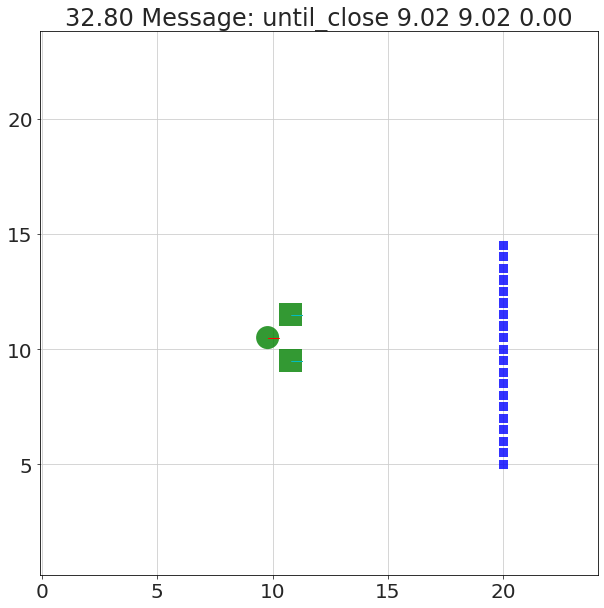

In [15]:
env=FrictionEnvironment(24,24)  # size of the environment
robot=Robot(env)

build(robot)
robot.controller=Controller(state_machine)
robot.controller.monitor=monitor

# put a bunch of blocks
for y in arange(5,15,0.5):
    Box(env,20,y,width=0.4,height=0.4,density=0.01)

run_sim(env,robot.controller,
        total_time=100,  # seconds
        dt=1/60,
        dt_display=0.5,  # make this larger for a faster display
       )

In [16]:
state_machine=StateMachine(
    ([forward,until_close,backward,until_far],'forward'),
)

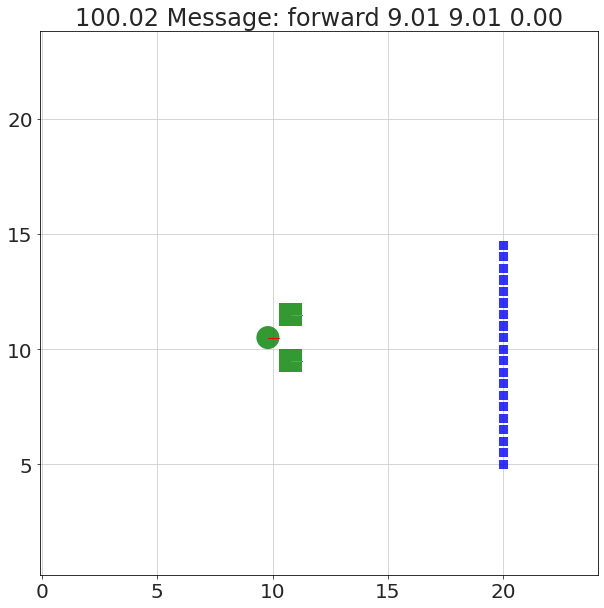

In [17]:
env=FrictionEnvironment(24,24)  # size of the environment
robot=Robot(env)

build(robot)
robot.controller=Controller(state_machine)
robot.controller.monitor=monitor

# put a bunch of blocks
for y in arange(5,15,0.5):
    Box(env,20,y,width=0.4,height=0.4,density=0.01)

run_sim(env,robot.controller,
        total_time=100,  # seconds
        dt=1/60,
        dt_display=0.5,  # make this larger for a faster display
       )

In [79]:
def forward(t,robot):
    robot['left'].F=4
    robot['right'].F=4
    return True

def stop(t,robot):
    robot['left'].F=0
    robot['right'].F=0
    return True


def backward(t,robot):
    robot['left'].F=-4
    robot['right'].F=-4
    return True

def until_close(t,robot):
    distance=robot['center'].read_distance()
    if distance<6:
        return True
        
        
        
def look_left(t,robot):
    robot['center'].τ=.2

    if robot['center'].angle>45:
        robot['center'].τ=0
        return True
    
def save_distance_left(t,robot):
    robot['center'].left_distance=robot['center'].read_distance()
    return True

def look_right(t,robot):
    robot['center'].τ=-.2
    
    if robot['center'].angle>300 and robot['center'].angle<315:
        robot['center'].τ=0
        return True
    
def save_distance_right(t,robot):
    robot['center'].right_distance=robot['center'].read_distance()
    return True
    
    
def look_straight(t,robot):
    robot['center'].τ=.2
    
    if robot['center'].angle>0 and robot['center'].angle<10:
        robot['center'].τ=0
        return True
    
    
    
def choose_right_or_left(t,robot):
    
    L,R=robot['center'].left_distance,robot['center'].right_distance
    
    if L>1.1*R:
        return 'turn_left_45'
    elif R>1.1*L:
        return 'turn_right_45'
    else:
        return 'backward'
    
    
    
def delta_angle(a1,a2):
    return 180 - abs(abs(a1 - a2) - 180)


def turn_left_45(t,robot):
    
    robot['left'].F=-4
    robot['right'].F=4
    
    if delta_angle(robot['right'].angle,0)>45:
        return True
    
def turn_right_45(t,robot):
    robot['left'].F=4
    robot['right'].F=-4
    
    if delta_angle(robot['right'].angle,0)>45:
        return True
    
    
    
def until_closer(t,robot):
    distance=robot['right'].read_distance()
    if distance<2:
        return True
    
    
def until_far(t,robot):
    distance=robot['center'].read_distance()
    if distance>12:
        return True        

In [80]:
forward_stop=StateMachine(
    (forward,'until_closer'),
    ( (until_closer,stop),'_end_simulation'),
    name='forward_stop'
)

state_machine=StateMachine(
    (forward,'until_close'),
    ( (until_close,stop),'look_left'),
    ( (look_left,save_distance_left,wait(2)),'look_right'),
    ( (look_right,save_distance_right,wait(2)),'look_straight'),
    (look_straight,'choose_right_or_left'),
    (choose_right_or_left,'_end_simulation'),
    (turn_left_45,'forward_stop'),
    (turn_right_45,'forward_stop'),
    (forward_stop,'_end_simulation'),
    ( (backward,until_far),'_end_simulation'),
    
)

state_machine.states


OrderedDict([('forward',
              {'actions': [<function __main__.forward(t, robot)>],
               'next': 'until_close'}),
             ('until_close',
              {'actions': (<function __main__.until_close(t, robot)>,
                <function __main__.stop(t, robot)>),
               'next': 'look_left'}),
             ('look_left',
              {'actions': (<function __main__.look_left(t, robot)>,
                <function __main__.save_distance_left(t, robot)>,
                <function RobotSim373.robotsim.wait.<locals>._wait(t, robot)>),
               'next': 'look_right'}),
             ('look_right',
              {'actions': (<function __main__.look_right(t, robot)>,
                <function __main__.save_distance_right(t, robot)>,
                <function RobotSim373.robotsim.wait.<locals>._wait(t, robot)>),
               'next': 'look_straight'}),
             ('look_straight',
              {'actions': [<function __main__.look_straight(t, robot)>],
        

In [81]:

def monitor(t,robot):
    robot.message=robot.controller.current_state,robot['left'].read_distance(),robot['right'].read_distance(),robot['center'].read_distance(),robot['center'].angle


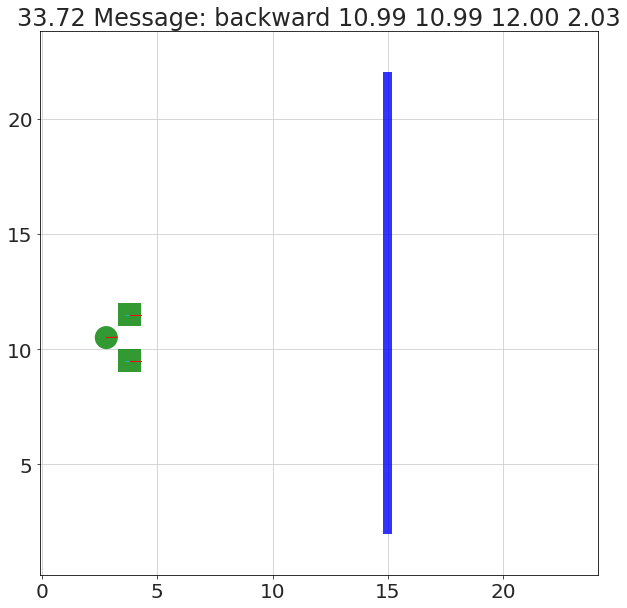

In [83]:
env=FrictionEnvironment(24,24)  # size of the environment
robot=Robot(env)

build(robot)
robot.controller=Controller(state_machine,verbose=False)
robot.controller.monitor=monitor

#Box(env,15,15,width=0.4,height=10,density=0.01)

#Box(env,15,7,width=0.4,height=10,density=0.01)

Box(env,15,12,width=0.4,height=20,density=0.01)


# put a bunch of blocks
# for y in arange(10,23,0.5):
#     Box(env,15,y,width=0.4,height=0.4,density=0.01)

# # put a bunch of blocks
# for y in arange(1,13,0.5):
#     Box(env,15,y,width=0.4,height=0.4,density=0.01)

# put a bunch of blocks
# for y in arange(1,23,0.5):
#     Box(env,15,y,width=0.4,height=0.4,density=0.01)
    
    
run_sim(env,robot.controller,
        total_time=100,  # seconds
        dt=1/60,
        dt_display=0.5,  # make this larger for a faster display
       )

In [12]:
forward.__name__

'forward'